# 01 — Data Quality Analysis

**NovaCred Credit Application Governance | DEGO 2606**

**Author:** Jasper Gräfe (Data Engineer)

---

## Objectives

Assess the quality of `raw_credit_applications.json` across four dimensions:

| Dimension | Description |
|-----------|-------------|
| Completeness | Are all required fields present and populated? |
| Consistency | Are values formatted and coded uniformly? |
| Validity | Do values conform to expected ranges and formats? |
| Accuracy | Are values plausible and internally consistent? |

---

## Sections

0. Setup & Data Loading
1. Dataset Overview & Schema Profiling
2. Completeness Analysis
3. Consistency Analysis
4. Validity Analysis
5. Accuracy Analysis
6. Consolidated Quality Report & Clean Export
7. Quality Scores & Governance Notes

---
## Section 0 — Setup & Data Loading

In [1]:
import json
import re
import pathlib
import collections
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = pathlib.Path('../data/raw_credit_applications.json')

with open(DATA_PATH, 'r') as f:
    raw_data = json.load(f)

print(f'Records loaded: {len(raw_data)}')
print(f'\nSample record keys: {list(raw_data[0].keys())}')

Records loaded: 502

Sample record keys: ['_id', 'applicant_info', 'financials', 'spending_behavior', 'decision', 'processing_timestamp']


In [3]:
def flatten_record(record):
    flat = {'_id': record.get('_id')}
    flat.update(record.get('applicant_info', {}))
    flat.update(record.get('financials', {}))
    decision = record.get('decision', {})
    flat['loan_approved']    = decision.get('loan_approved')
    flat['interest_rate']    = decision.get('interest_rate')
    flat['approved_amount']  = decision.get('approved_amount')
    flat['rejection_reason'] = decision.get('rejection_reason')
    return flat

df = pd.DataFrame([flatten_record(r) for r in raw_data])
print(f'Shape: {df.shape}')
df.head(3)

Shape: (502, 17)


,_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code,annual_income,credit_history_months,debt_to_income,savings_balance,loan_approved,interest_rate,approved_amount,rejection_reason,annual_salary
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,0.20,31212,False,NaN,NaN,algorithm_risk_score,NaN
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,0.18,17915,False,NaN,NaN,algorithm_risk_score,NaN
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,0.21,37909,True,3.7,59000.0,None,NaN


---
## Section 1 — Dataset Overview & Schema Profiling

In [4]:
# Basic overview
print(f'Shape: {df.shape}')
print(f'\nColumn dtypes:')
print(df.dtypes)

Shape: (502, 17)

Column dtypes:
_id                       object
full_name                 object
email                     object
ssn                       object
ip_address                object
gender                    object
date_of_birth             object
zip_code                  object
annual_income             object
credit_history_months      int64
debt_to_income           float64
savings_balance            int64
loan_approved               bool
interest_rate            float64
approved_amount          float64
rejection_reason          object
annual_salary            float64
dtype: object


In [5]:
# Discover all top-level keys present across every record
all_top_keys = set()
for record in raw_data:
    all_top_keys.update(record.keys())

expected_top_keys = {'_id', 'applicant_info', 'financials', 'decision', 'spending_behavior'}
extra_keys = all_top_keys - expected_top_keys

print(f'Top-level keys found:  {sorted(all_top_keys)}')
print(f'Extra (not in schema): {sorted(extra_keys)}')

Top-level keys found:  ['_id', 'applicant_info', 'decision', 'financials', 'loan_purpose', 'notes', 'processing_timestamp', 'spending_behavior']
Extra (not in schema): ['loan_purpose', 'notes', 'processing_timestamp']


In [6]:
# Add any discovered extra fields to the DataFrame
for key in sorted(extra_keys):
    df[key] = [r.get(key) for r in raw_data]

print(f'Updated shape: {df.shape}')
df.head(3)

Updated shape: (502, 20)


,_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code,annual_income,credit_history_months,debt_to_income,savings_balance,loan_approved,interest_rate,approved_amount,rejection_reason,annual_salary,loan_purpose,notes,processing_timestamp
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,0.20,31212,False,NaN,NaN,algorithm_risk_score,NaN,None,None,2024-01-15T00:00:00Z
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,0.18,17915,False,NaN,NaN,algorithm_risk_score,NaN,None,None,None
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,0.21,37909,True,3.7,59000.0,None,NaN,vacation,None,None


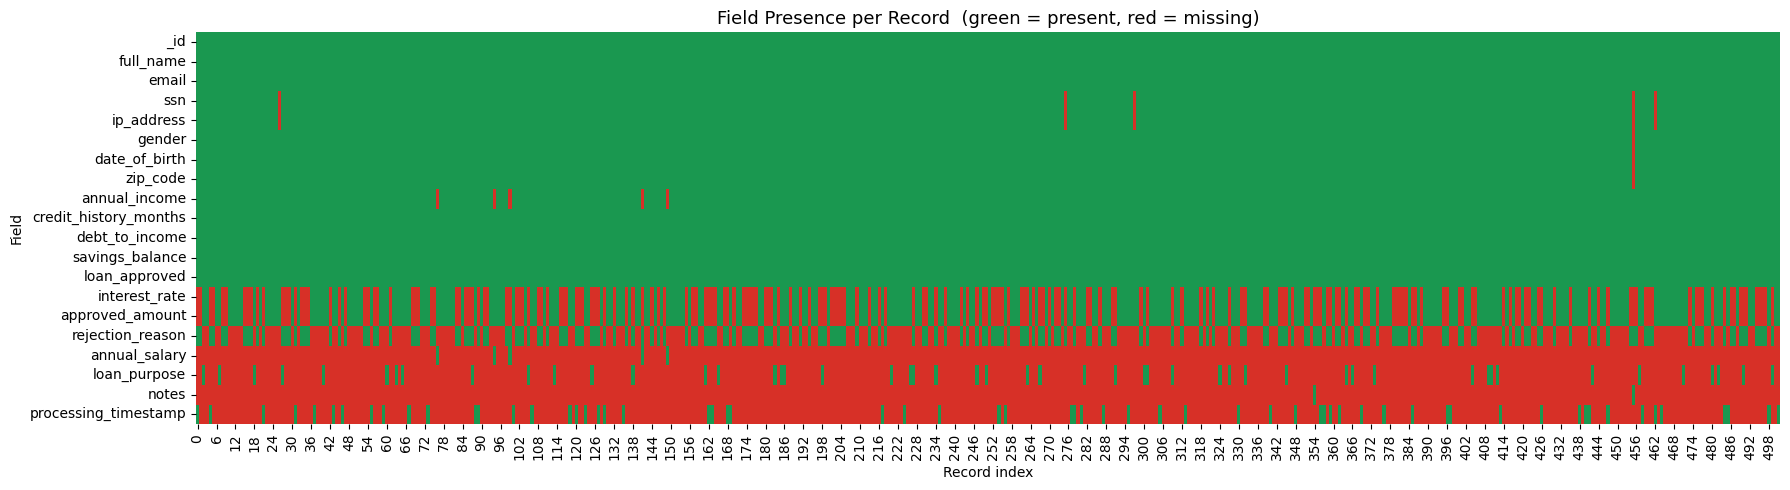

In [7]:
# Field presence heatmap — green = present, red = missing
presence = df.notna().astype(int)

fig, ax = plt.subplots(figsize=(18, 5))
sns.heatmap(
    presence.T,
    cmap=['#d73027', '#1a9850'],
    cbar=False,
    ax=ax,
    linewidths=0
)
ax.set_title('Field Presence per Record  (green = present, red = missing)', fontsize=13)
ax.set_xlabel('Record index')
ax.set_ylabel('Field')
plt.tight_layout()
plt.savefig('../reports/dq_field_presence_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Per-field completeness table
completeness = pd.DataFrame({
    'present': df.notna().sum(),
    'missing': df.isna().sum(),
    'pct_present': (df.notna().sum() / len(df) * 100).round(1)
}).sort_values('pct_present')

print(f'Total records: {len(df)}')
print()
print(completeness.to_string())

Total records: 502

                       present  missing  pct_present
notes                        2      500          0.4
annual_salary                5      497          1.0
loan_purpose                50      452         10.0
processing_timestamp        62      440         12.4
rejection_reason           210      292         41.8
approved_amount            292      210         58.2
interest_rate              292      210         58.2
ssn                        497        5         99.0
ip_address                 497        5         99.0
annual_income              497        5         99.0
gender                     501        1         99.8
date_of_birth              501        1         99.8
zip_code                   501        1         99.8
_id                        502        0        100.0
savings_balance            502        0        100.0
debt_to_income             502        0        100.0
email                      502        0        100.0
full_name                 

---
## Section 2 — Completeness Analysis

In [9]:

# ── 2.1  Required vs optional field classification ────────────────────────────
REQUIRED_FIELDS = [
    '_id', 'full_name', 'email', 'ssn', 'gender',
    'date_of_birth', 'zip_code', 'annual_income',
    'credit_history_months', 'debt_to_income',
    'savings_balance', 'loan_approved',
]
OPTIONAL_FIELDS = [c for c in df.columns if c not in REQUIRED_FIELDS]

print('Required fields:', REQUIRED_FIELDS)
print('Optional fields:', OPTIONAL_FIELDS)


Required fields: ['_id', 'full_name', 'email', 'ssn', 'gender', 'date_of_birth', 'zip_code', 'annual_income', 'credit_history_months', 'debt_to_income', 'savings_balance', 'loan_approved']
Optional fields: ['ip_address', 'interest_rate', 'approved_amount', 'rejection_reason', 'annual_salary', 'loan_purpose', 'notes', 'processing_timestamp']


In [10]:

# ── 2.2  Missing values per record ────────────────────────────────────────────
df['n_missing_required'] = df[REQUIRED_FIELDS].isna().sum(axis=1)
df['n_missing_all']      = df.isna().sum(axis=1)

print('Records with ≥1 required field missing:',
      (df['n_missing_required'] > 0).sum())
print('Records fully complete (all required fields present):',
      (df['n_missing_required'] == 0).sum())
print()
print('Distribution of missing required fields per record:')
print(df['n_missing_required'].value_counts().sort_index().to_string())


Records with ≥1 required field missing: 10
Records fully complete (all required fields present): 492

Distribution of missing required fields per record:
n_missing_required
0    492
1      9
4      1


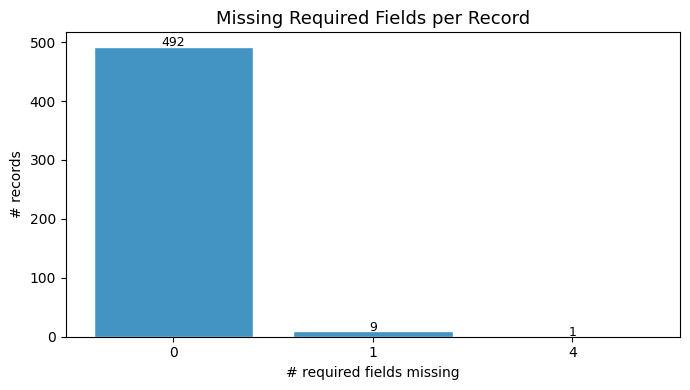

In [11]:

# ── 2.3  Histogram: how many required fields are missing per record ────────────
fig, ax = plt.subplots(figsize=(7, 4))
counts = df['n_missing_required'].value_counts().sort_index()
ax.bar(counts.index.astype(str), counts.values, color='#4393c3', edgecolor='white')
ax.set_title('Missing Required Fields per Record', fontsize=13)
ax.set_xlabel('# required fields missing')
ax.set_ylabel('# records')
for i, (x, y) in enumerate(zip(counts.index, counts.values)):
    ax.text(i, y + 1, str(y), ha='center', fontsize=9)
plt.tight_layout()
plt.savefig('../reports/dq_missing_required_histogram.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:

# ── 2.4  Duplicate detection ──────────────────────────────────────────────────

# 2.4a — Exact full-row duplicates (excluding _id)
content_cols = [c for c in df.columns if c not in ('_id', 'n_missing_required', 'n_missing_all')]
exact_dupes = df[df.duplicated(subset=content_cols, keep=False)]
print(f'Exact duplicate rows (same content, different _id): {len(exact_dupes)}')

# 2.4b — Duplicate _ids
dup_ids = df[df.duplicated(subset=['_id'], keep=False)]
print(f'Duplicate _id values: {len(dup_ids)}')

# 2.4c — Duplicate SSNs (potential re-applications / data entry errors)
dup_ssn = df[df.duplicated(subset=['ssn'], keep=False) & df['ssn'].notna()]
print(f'Records sharing an SSN with another record: {len(dup_ssn)}')
if len(dup_ssn):
    print(dup_ssn[['_id', 'full_name', 'ssn', 'email']].sort_values('ssn').to_string(index=False))

# 2.4d — Duplicate emails
dup_email = df[df.duplicated(subset=['email'], keep=False) & df['email'].notna()]
print(f'\nRecords sharing an email with another record: {len(dup_email)}')
if len(dup_email):
    print(dup_email[['_id', 'full_name', 'ssn', 'email']].sort_values('email').to_string(index=False))


Exact duplicate rows (same content, different _id): 0
Duplicate _id values: 4
Records sharing an SSN with another record: 6
    _id      full_name         ssn                           email
app_042   Joseph Lopez 652-70-5530         joseph.lopez1@gmail.com
app_042   Joseph Lopez 652-70-5530         joseph.lopez1@gmail.com
app_088 Susan Martinez 780-24-9300 susan.martinez83@protonmail.com
app_016    Gary Wilson 780-24-9300         gary.wilson85@yahoo.com
app_101   Sandra Smith 937-72-8731       sandra.smith99@icloud.com
app_234    Samuel Hill 937-72-8731    samuel.hill67@protonmail.com

Records sharing an email with another record: 11
    _id         full_name         ssn                       email
app_075 Margaret Williams         NaN                            
app_413   Anthony Jackson 584-37-2562                            
app_120    Carolyn Martin         NaN                            
app_268    Larry Williams         NaN                            
app_377        Anna White 6

In [13]:

# ── 2.5  Incomplete record flagging & summary ─────────────────────────────────
df['is_incomplete'] = df['n_missing_required'] > 0

incomplete = df[df['is_incomplete']][['_id', 'full_name'] + REQUIRED_FIELDS + ['n_missing_required']]
print(f'Incomplete records (missing ≥1 required field): {df["is_incomplete"].sum()} / {len(df)}')
print()

# Show which required fields are missing in those records
missing_req_by_field = df[df['is_incomplete']][REQUIRED_FIELDS].isna().sum()
print('Required fields with gaps:')
print(missing_req_by_field[missing_req_by_field > 0].sort_values(ascending=False).to_string())
print()
print('Incomplete records sample:')
print(incomplete.head(10).to_string(index=False))


Incomplete records (missing ≥1 required field): 10 / 502

Required fields with gaps:
ssn              5
annual_income    5
gender           1
date_of_birth    1
zip_code         1

Incomplete records sample:
    _id         full_name     _id         full_name                       email         ssn gender date_of_birth zip_code annual_income  credit_history_months  debt_to_income  savings_balance  loan_approved  n_missing_required
app_075 Margaret Williams app_075 Margaret Williams                                     NaN                                       61000                     29            0.15            25894           True                   1
app_436     Amanda Torres app_436     Amanda Torres   amanda.torres59@gmail.com 135-51-1195      F    1998-06-02    90217           NaN                     35            0.13            10311           True                   1
app_421      Donald Baker app_421      Donald Baker   donald.baker60@icloud.com 344-50-4287   Male    1982-07-1

In [14]:

# ── 2.6  Section 2 summary ────────────────────────────────────────────────────
completeness_summary = {
    'Total records':                         len(df),
    'Fully complete (required fields)':      int((df['n_missing_required'] == 0).sum()),
    'Incomplete (≥1 required field missing)': int(df['is_incomplete'].sum()),
    'Exact content duplicates':              len(exact_dupes),
    'Duplicate _ids':                        len(dup_ids),
    'Duplicate SSNs':                        len(dup_ssn),
    'Duplicate emails':                      len(dup_email),
}

print('=== Section 2 — Completeness Summary ===')
for k, v in completeness_summary.items():
    print(f'  {k:<45} {v}')


=== Section 2 — Completeness Summary ===
  Total records                                 502
  Fully complete (required fields)              492
  Incomplete (≥1 required field missing)        10
  Exact content duplicates                      0
  Duplicate _ids                                4
  Duplicate SSNs                                6
  Duplicate emails                              11


---
## Section 3 — Consistency Analysis

In [15]:

# ── 3.1  Categorical coding — gender ─────────────────────────────────────────
# Start by looking at the raw distribution of the gender field before touching anything.

print('Raw gender value counts (incl. NaN):')
print(df['gender'].value_counts(dropna=False).to_string())


Raw gender value counts (incl. NaN):
gender
Male      195
Female    193
F          58
M          53
            2
NaN         1


In [16]:

# Two coding conventions are present: full words ("Male", "Female") and single-letter
# abbreviations ("M", "F"). Standardise everything to the full-word form.

GENDER_MAP = {'M': 'Male', 'F': 'Female'}
df['gender_clean'] = df['gender'].replace(GENDER_MAP)

changed = df['gender'].notna() & (df['gender'] != df['gender_clean'])
print(f"Records with non-standard gender code: {changed.sum()}")
print()
print("Before → After:")
print(
    df.loc[changed, ['_id', 'gender', 'gender_clean']]
      .rename(columns={'gender': 'raw', 'gender_clean': 'normalised'})
      .to_string(index=False)
)
print()
print('Normalised gender distribution:')
print(df['gender_clean'].value_counts(dropna=False).to_string())


Records with non-standard gender code: 111

Before → After:
    _id raw normalised
app_037   M       Male
app_184   M       Male
app_275   F     Female
app_246   F     Female
app_307   M       Male
app_352   F     Female
app_289   M       Male
app_080   M       Male
app_452   F     Female
app_167   F     Female
app_276   F     Female
app_386   F     Female
app_065   F     Female
app_279   M       Male
app_093   F     Female
app_436   F     Female
app_483   M       Male
app_100   M       Male
app_107   M       Male
app_088   F     Female
app_479   F     Female
app_260   M       Male
app_029   F     Female
app_261   M       Male
app_016   M       Male
app_151   M       Male
app_071   F     Female
app_365   M       Male
app_500   M       Male
app_262   F     Female
app_283   F     Female
app_083   M       Male
app_384   M       Male
app_245   M       Male
app_252   F     Female
app_364   F     Female
app_474   F     Female
app_430   F     Female
app_019   M       Male
app_424   M       Ma

In [17]:

# ── 3.2  Date format — date_of_birth ─────────────────────────────────────────
# Expected format throughout the schema is ISO 8601 (YYYY-MM-DD).
# Check whether all non-null values actually conform.

import re

non_iso_mask = (
    df['date_of_birth'].notna() &
    ~df['date_of_birth'].astype(str).str.fullmatch(r'\d{4}-\d{2}-\d{2}')
)

print(f"Non-ISO date_of_birth values found: {non_iso_mask.sum()}")
if non_iso_mask.sum():
    print()
    print(df.loc[non_iso_mask, ['_id', 'date_of_birth']].to_string(index=False))


Non-ISO date_of_birth values found: 161

    _id date_of_birth
app_275    14/02/1982
app_099    28/01/1990
app_320    01/12/1978
app_307    1990/07/26
app_173    18/07/1979
app_289    20/04/1979
app_075              
app_274    1986/11/20
app_276    1995/05/07
app_386    03/20/1968
app_178    20/07/1997
app_285    1987/06/28
app_420    1988/04/06
app_130    03/10/1981
app_108    14/06/1975
app_497    04/20/1994
app_367    04/08/1979
app_160    29/12/1982
app_228    14/12/1987
app_039    30/09/1978
app_492    1994/03/03
app_372    11/03/1967
app_392    28/11/1998
app_264    1996/04/07
app_154    12/16/1985
app_114    1991/03/01
app_323    08/11/1981
app_479    1983/11/08
app_260    09/10/1967
app_247    1999/06/16
app_059    1992/11/21
app_297    02/18/1983
app_223    2000/12/28
app_261    12/28/1972
app_407    1990/11/09
app_014    14/01/1995
app_145    04/10/1990
app_134    06/10/1993
app_238    11/03/1988
app_057    1990/11/08
app_391    29/03/1963
app_271    07/28/1988
app_005    19

In [18]:

# Normalise the offending format (YYYY/MM/DD → YYYY-MM-DD).

def normalise_date(val):
    if pd.isna(val):
        return val
    s = str(val).strip()
    if re.match(r'^\d{4}/\d{2}/\d{2}$', s):
        return s.replace('/', '-')
    return s

df['date_of_birth_clean'] = df['date_of_birth'].apply(normalise_date)

fixed = df['date_of_birth'] != df['date_of_birth_clean']
print(f"Records with date format corrected: {fixed.sum()}")
print()
print(df.loc[fixed, ['_id', 'date_of_birth', 'date_of_birth_clean']].to_string(index=False))


Records with date format corrected: 57

    _id date_of_birth date_of_birth_clean
app_307    1990/07/26          1990-07-26
app_274    1986/11/20          1986-11-20
app_276    1995/05/07          1995-05-07
app_285    1987/06/28          1987-06-28
app_420    1988/04/06          1988-04-06
app_492    1994/03/03          1994-03-03
app_264    1996/04/07          1996-04-07
app_114    1991/03/01          1991-03-01
app_479    1983/11/08          1983-11-08
app_247    1999/06/16          1999-06-16
app_059    1992/11/21          1992-11-21
app_223    2000/12/28          2000-12-28
app_407    1990/11/09          1990-11-09
app_057    1990/11/08          1990-11-08
app_005    1960/06/19          1960-06-19
app_444    1981/10/28          1981-10-28
app_255    1991/08/05          1991-08-05
app_490    1987/04/13          1987-04-13
app_073    1985/02/02          1985-02-02
app_226    1982/04/18          1982-04-18
app_429    1996/02/26          1996-02-26
app_384    1997/02/27          1997-

In [19]:

# ── 3.3  Data-type inconsistency — annual_income ──────────────────────────────
# The column has dtype 'object', which means it holds mixed types.
# Classify each non-null entry to see what's actually in there.

print(f"annual_income dtype: {df['annual_income'].dtype}")
print()

def classify_type(v):
    if pd.isna(v):
        return 'missing'
    try:
        float(v)
        return 'numeric (int / numeric string)'
    except (ValueError, TypeError):
        return 'non-numeric string'

type_counts = df['annual_income'].apply(classify_type).value_counts()
print('annual_income value-type breakdown:')
print(type_counts.to_string())
print()

# annual_income has 5 missing values, and annual_salary has exactly 5 non-null values.
# Check whether these are the same records — i.e., the field was named wrong in some entries.
has_salary     = df['annual_salary'].notna()
missing_income = df['annual_income'].isna()
overlap        = df[has_salary & missing_income][['_id', 'annual_income', 'annual_salary']]

print(f"Records with annual_salary (not null): {has_salary.sum()}")
print(f"Records with annual_income missing:    {missing_income.sum()}")
print(f"Records in both (likely field-name mismatch): {len(overlap)}")
print()
print(overlap.to_string(index=False))


annual_income dtype: object

annual_income value-type breakdown:
annual_income
numeric (int / numeric string)    497
missing                             5

Records with annual_salary (not null): 5
Records with annual_income missing:    5
Records in both (likely field-name mismatch): 5

    _id annual_income  annual_salary
app_436           NaN        45000.0
app_421           NaN        46000.0
app_479           NaN        94000.0
app_463           NaN        86000.0
app_449           NaN        75000.0


In [20]:

# Remediate: coerce annual_income to numeric, then fill the 5 gaps from annual_salary.

df['annual_income_clean'] = pd.to_numeric(df['annual_income'], errors='coerce')
df['annual_income_clean'] = df['annual_income_clean'].fillna(df['annual_salary'])

still_missing = df['annual_income_clean'].isna().sum()
print(f"annual_income_clean — missing after remediation: {still_missing}")
print(f"annual_income_clean dtype: {df['annual_income_clean'].dtype}")
print()
print("Records rescued from annual_salary:")
print(df.loc[overlap.index, ['_id', 'annual_salary', 'annual_income_clean']].to_string(index=False))


annual_income_clean — missing after remediation: 0
annual_income_clean dtype: float64

Records rescued from annual_salary:
    _id  annual_salary  annual_income_clean
app_436        45000.0              45000.0
app_421        46000.0              46000.0
app_479        94000.0              94000.0
app_463        86000.0              86000.0
app_449        75000.0              75000.0


In [21]:

# ── 3.4  Other categorical fields — quick survey ──────────────────────────────
# Check rejection_reason and loan_purpose for unexpected or inconsistently named values.

print('=== rejection_reason value counts ===')
print(df['rejection_reason'].value_counts(dropna=False).to_string())
print()
print('=== loan_purpose value counts ===')
print(df['loan_purpose'].value_counts(dropna=False).to_string())


=== rejection_reason value counts ===
rejection_reason
None                           292
algorithm_risk_score           170
insufficient_credit_history     23
high_dti_ratio                  13
low_income                       4

=== loan_purpose value counts ===
loan_purpose
None                  452
medical                 8
education               7
vacation                6
debt_consolidation      6
wedding                 6
moving                  5
personal                4
auto                    3
home_improvement        3
business                2


In [22]:

# ── 3.5  Section 3 — Consistency Summary ──────────────────────────────────────

gender_fixed = int((df['gender'].notna() & (df['gender'] != df['gender_clean'])).sum())
date_fixed   = int((df['date_of_birth'] != df['date_of_birth_clean']).sum())
salary_fixed = int(len(overlap))
income_unparseable = int(
    df['annual_income'].notna().sum() -
    df.loc[df['annual_income'].notna(), 'annual_income_clean'].notna().sum()
)

consistency_summary = {
    'Gender codes normalised (M → Male / F → Female)':       gender_fixed,
    'Date formats normalised (YYYY/MM/DD → YYYY-MM-DD)':     date_fixed,
    'annual_salary records merged into annual_income_clean':  salary_fixed,
    'annual_income entries unparseable (coerced to NaN)':     income_unparseable,
}

print('=== Section 3 — Consistency Summary ===')
for k, v in consistency_summary.items():
    print(f'  {k:<55} {v}')


=== Section 3 — Consistency Summary ===
  Gender codes normalised (M → Male / F → Female)         111
  Date formats normalised (YYYY/MM/DD → YYYY-MM-DD)       57
  annual_salary records merged into annual_income_clean   5
  annual_income entries unparseable (coerced to NaN)      0


---
## Section 4 — Validity Analysis

In [23]:
# To be implemented

---
## Section 5 — Accuracy Analysis

In [24]:
# To be implemented

---
## Section 6 — Consolidated Quality Report & Clean Export

In [25]:
# To be implemented

---
## Section 7 — Quality Scores & Governance Notes

In [26]:
# To be implemented